In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_groq

How to Review Tool Call: Interuption node

In [14]:
def human_review_node(state) -> Command[Literal["call_llm", "run_tool"]]:
    # this is the value we'll be providing via Command(resume=<human_review>)
    human_review = interrupt(
        {
            "question": "Is this correct?",
            # Surface tool calls for review
            "tool_call": tool_call
        }
    )

    review_action, review_data = human_review

    # Approve the tool call and continue
    if review_action == "continue":
        return Command(goto="run_tool")

    # Modify the tool call manually and then continue
    elif review_action == "update":
        ...
        updated_msg = get_updated_msg(review_data)
        return Command(goto="run_tool", update={"messages": [updated_message]})

    # Give natural language feedback, and then pass that back to the agent
    elif review_action == "feedback":
        ...
        feedback_msg = get_feedback_msg(review_data)
        return Command(goto="call_llm", update={"messages": [feedback_msg]})

Setting Up environment

In [15]:
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GROQ_API_KEY") 

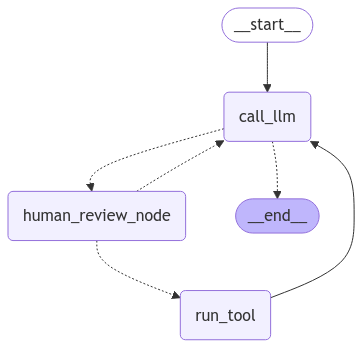

In [18]:
import os
from typing_extensions import Literal
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Command, interrupt
from langchain_core.tools import tool
from langchain_core.messages import AIMessage
from IPython.display import Image, display


@tool
def weather_search(city: str):
    """Search for the weather"""
    print("----")
    print(f"Searching for: {city}")
    print("----")
    return "Sunny!"



model = ChatGroq(model_name="llama-3.3-70b-versatile").bind_tools([weather_search])



class State(MessagesState):
    """Simple state."""


def call_llm(state):
    return {"messages": [model.invoke(state["messages"])]}


def human_review_node(state) -> Command[Literal["call_llm", "run_tool"]]:
    last_message = state["messages"][-1]
    tool_call = last_message.tool_calls[-1]

    # this is the value we'll be providing via Command(resume=<human_review>)
    human_review = interrupt(
        {
            "question": "Is this correct?",
            # Surface tool calls for review
            "tool_call": tool_call,
        }
    )

    review_action = human_review["action"]
    review_data = human_review.get("data")

    # if approved, call the tool
    if review_action == "continue":
        return Command(goto="run_tool")

    # update the AI message AND call tools
    elif review_action == "update":
        updated_message = {
            "role": "ai",
            "content": last_message.content,
            "tool_calls": [
                {
                    "id": tool_call["id"],
                    "name": tool_call["name"],
                    # This the update provided by the human
                    "args": review_data,
                }
            ],
            # This is important - this needs to be the same as the message you replacing!
            # Otherwise, it will show up as a separate message
            "id": last_message.id,
        }
        return Command(goto="run_tool", update={"messages": [updated_message]})

    # provide feedback to LLM
    elif review_action == "feedback":
        # NOTE: we're adding feedback message as a ToolMessage
        # to preserve the correct order in the message history
        # (AI messages with tool calls need to be followed by tool call messages)
        tool_message = {
            "role": "tool",
            # This is our natural language feedback
            "content": review_data,
            "name": tool_call["name"],
            "tool_call_id": tool_call["id"],
        }
        return Command(goto="call_llm", update={"messages": [tool_message]})


def run_tool(state):
    new_messages = []
    tools = {"weather_search": weather_search}
    tool_calls = state["messages"][-1].tool_calls
    for tool_call in tool_calls:
        tool = tools[tool_call["name"]]
        result = tool.invoke(tool_call["args"])
        new_messages.append(
            {
                "role": "tool",
                "name": tool_call["name"],
                "content": result,
                "tool_call_id": tool_call["id"],
            }
        )
    return {"messages": new_messages}


def route_after_llm(state) -> Literal[END, "human_review_node"]:
    if len(state["messages"][-1].tool_calls) == 0:
        return END
    else:
        return "human_review_node"


builder = StateGraph(State)
builder.add_node(call_llm)
builder.add_node(run_tool)
builder.add_node(human_review_node)
builder.add_edge(START, "call_llm")
builder.add_conditional_edges("call_llm", route_after_llm)
builder.add_edge("run_tool", "call_llm")

# Set up memory
memory = MemorySaver()

# Add
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

EXample with No Review

In [19]:
# Input
initial_input = {"messages": [{"role": "user", "content": "hi!"}]}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

{'call_llm': {'messages': [AIMessage(content="I'm here to help. How can I assist you today? Do you want to search for the weather in a specific city?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 210, 'total_tokens': 237, 'completion_time': 0.098181818, 'prompt_time': 0.026082251, 'queue_time': 0.757299561, 'total_time': 0.124264069}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_4196e754db', 'finish_reason': 'stop', 'logprobs': None}, id='run-5b3add17-5feb-4cc3-b1fa-b65696f322bf-0', usage_metadata={'input_tokens': 210, 'output_tokens': 27, 'total_tokens': 237})]}}




EXAMPLE OF APPROVING TOOL

In [20]:
# Input
initial_input = {"messages": [{"role": "user", "content": "what's the weather in tx?"}]}

# Thread
thread = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

{'call_llm': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_s07v', 'function': {'arguments': '{"city": "Texas"}', 'name': 'weather_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 215, 'total_tokens': 230, 'completion_time': 0.054545455, 'prompt_time': 0.025612847, 'queue_time': 0.020334394, 'total_time': 0.080158302}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_fcc3b74982', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-870cf9c1-eb66-4a00-8d63-b58b4e701408-0', tool_calls=[{'name': 'weather_search', 'args': {'city': 'Texas'}, 'id': 'call_s07v', 'type': 'tool_call'}], usage_metadata={'input_tokens': 215, 'output_tokens': 15, 'total_tokens': 230})]}}


{'__interrupt__': (Interrupt(value={'question': 'Is this correct?', 'tool_call': {'name': 'weather_search', 'args': {'city': 'Texas'}, 'id': 'call_s07v', 'type': 'tool_call'}}, resumable=True, ns=['human_review

In [21]:
print("Pending Executions!")
print(graph.get_state(thread).next)

Pending Executions!
('human_review_node',)


To approve th call, we just need to use continue the thread

In [22]:
for event in graph.stream(
    # provide value
    Command(resume={"action": "continue"}),
    thread,
    stream_mode="updates",
):
    print(event)
    print("\n")

{'human_review_node': None}


----
Searching for: Texas
----
{'run_tool': {'messages': [{'role': 'tool', 'name': 'weather_search', 'content': 'Sunny!', 'tool_call_id': 'call_s07v'}]}}


{'call_llm': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6nv2', 'function': {'arguments': '{"city": "Houston"}', 'name': 'weather_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 129, 'prompt_tokens': 243, 'total_tokens': 372, 'completion_time': 0.469090909, 'prompt_time': 0.028150403, 'queue_time': 0.023571911999999997, 'total_time': 0.497241312}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3884478861', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9c861c0d-b41e-48ee-982c-a73d15648a13-0', tool_calls=[{'name': 'weather_search', 'args': {'city': 'Houston'}, 'id': 'call_6nv2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 243, 'output_tokens': 129, 'total_tokens': 372})]}}


{'__inter

Editing the Tool call

In [33]:
# Input
initial_input = {"messages": [{"role": "user", "content": "what's the weather in tx?"}]}

# Thread
thread = {"configurable": {"thread_id": "3"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

{'call_llm': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_zdf0', 'function': {'arguments': '{"city": "Texas, USA"}', 'name': 'weather_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 479, 'total_tokens': 496, 'completion_time': 0.061818182, 'prompt_time': 0.055400783, 'queue_time': 0.038121459, 'total_time': 0.117218965}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_4196e754db', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ab3c4a63-611a-4129-9f77-38104efb53b8-0', tool_calls=[{'name': 'weather_search', 'args': {'city': 'Texas, USA'}, 'id': 'call_zdf0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 479, 'output_tokens': 17, 'total_tokens': 496})]}}


{'__interrupt__': (Interrupt(value={'question': 'Is this correct?', 'tool_call': {'name': 'weather_search', 'args': {'city': 'Texas, USA'}, 'id': 'call_zdf0', 'type': 'tool_call'}}, resumable=True, ns

In [27]:
print("Pending Executions!")
print(graph.get_state(thread).next)

Pending Executions!
('human_review_node',)


In [28]:
# Let's now continue executing from here
for event in graph.stream(
    Command(resume={"action": "update", "data": {"city": "Austin, USA"}}),
    thread,
    stream_mode="updates",
):
    print(event)
    print("\n")

{'human_review_node': {'messages': [{'role': 'ai', 'content': '', 'tool_calls': [{'id': 'call_nsqq', 'name': 'weather_search', 'args': {'city': 'Austin, USA'}}], 'id': 'run-cbfcc946-d565-4dd8-a626-876967ef766e-0'}]}}


----
Searching for: Austin, USA
----
{'run_tool': {'messages': [{'role': 'tool', 'name': 'weather_search', 'content': 'Sunny!', 'tool_call_id': 'call_nsqq'}]}}


{'call_llm': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_gzqa', 'function': {'arguments': '{"city": "Texas, USA"}', 'name': 'weather_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 308, 'total_tokens': 325, 'completion_time': 0.061818182, 'prompt_time': 0.035142758, 'queue_time': 0.057839364, 'total_time': 0.09696094}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3884478861', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6a20d48e-4d1d-4294-8c17-78950fbad8de-0', tool_calls=[{'name

GIVING FEEDBACK TO TOOL CALL

In [34]:
# Input
initial_input = {"messages": [{"role": "user", "content": "what's the weather in sf?"}]}

# Thread
thread = {"configurable": {"thread_id": "4"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

{'call_llm': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_d87q', 'function': {'arguments': '{"city": "San Francisco"}', 'name': 'weather_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 215, 'total_tokens': 231, 'completion_time': 0.058181818, 'prompt_time': 0.030586663, 'queue_time': 0.478613975, 'total_time': 0.088768481}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_4e32347616', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-49c49c66-4b7a-4b82-8a98-358d178da46d-0', tool_calls=[{'name': 'weather_search', 'args': {'city': 'San Francisco'}, 'id': 'call_d87q', 'type': 'tool_call'}], usage_metadata={'input_tokens': 215, 'output_tokens': 16, 'total_tokens': 231})]}}


{'__interrupt__': (Interrupt(value={'question': 'Is this correct?', 'tool_call': {'name': 'weather_search', 'args': {'city': 'San Francisco'}, 'id': 'call_d87q', 'type': 'tool_call'}}, resumable

In [35]:
print("Pending Executions!")
print(graph.get_state(thread).next)

Pending Executions!
('human_review_node',)


In [36]:
# Let's now continue executing from here
for event in graph.stream(
    # provide our natural language feedback!
    Command(
        resume={
            "action": "feedback",
            "data": "User requested changes: use <city, country> format for location",
        }
    ),
    thread,
    stream_mode="updates",
):
    print(event)
    print("\n")

{'human_review_node': {'messages': [{'role': 'tool', 'content': 'User requested changes: use <city, country> format for location', 'name': 'weather_search', 'tool_call_id': 'call_d87q'}]}}


{'call_llm': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1rvv', 'function': {'arguments': '{"city": "San Francisco, USA"}', 'name': 'weather_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 254, 'total_tokens': 272, 'completion_time': 0.065454545, 'prompt_time': 0.037673851, 'queue_time': 0.564261047, 'total_time': 0.103128396}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3884478861', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-48ba5f0b-19bc-4957-84fb-c92d27ec91cf-0', tool_calls=[{'name': 'weather_search', 'args': {'city': 'San Francisco, USA'}, 'id': 'call_1rvv', 'type': 'tool_call'}], usage_metadata={'input_tokens': 254, 'output_tokens': 18, 'total_tokens': 272}

In [37]:
print("Pending Executions!")
print(graph.get_state(thread).next)

Pending Executions!
('human_review_node',)


In [38]:
for event in graph.stream(
    Command(resume={"action": "continue"}), thread, stream_mode="updates"
):
    print(event)
    print("\n")

{'human_review_node': None}


----
Searching for: San Francisco, USA
----
{'run_tool': {'messages': [{'role': 'tool', 'name': 'weather_search', 'content': 'Sunny!', 'tool_call_id': 'call_1rvv'}]}}


{'call_llm': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5nrw', 'function': {'arguments': '{"city": "San Francisco, USA"}', 'name': 'weather_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 285, 'total_tokens': 303, 'completion_time': 0.065454545, 'prompt_time': 0.049109468, 'queue_time': 0.615458011, 'total_time': 0.114564013}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_4e32347616', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-45719ebb-541a-4731-bbd7-b035c880c681-0', tool_calls=[{'name': 'weather_search', 'args': {'city': 'San Francisco, USA'}, 'id': 'call_5nrw', 'type': 'tool_call'}], usage_metadata={'input_tokens': 285, 'output_tokens': 18, 'total_token